# Kaggle - Bike Sharing Demand - Data Exploration

### Important
* **For forecasting only use data from time up to the forecast period**
* Cost function is RMSE of log(1 + count), so it makes sense to optimise to predict log(1 + count)

### Questions
* Casual and registered users - should they be treated as separate data sets?

In [1]:
from __future__ import division
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.parser import parse
import warnings

%matplotlib inline

In [2]:
# Parse data from csv to np arrays
train_filename = 'data/train.csv'

train_datetime = np.loadtxt(train_filename, 
                            dtype=dt.datetime, 
                            converters={0: parse}, 
                            delimiter=',', 
                            skiprows=1, 
                            usecols=(0,))

train_year = np.asarray(list(d.year for d in train_datetime))
train_month = np.asarray(list(d.month for d in train_datetime))
train_day = np.asarray(list(d.day for d in train_datetime))
train_wday = np.asarray(list(d.isoweekday() for d in train_datetime))
train_hour = np.asarray(list(d.hour for d in train_datetime))

train_start_year = train_year[0]
train_month_since_start = train_month + (train_year - train_start_year) * 12

train_other = np.loadtxt(train_filename, 
                         delimiter=',', 
                         skiprows=1, 
                         usecols=range(1,12))

train_season = train_other[:, 0].astype(np.int64)
train_season_since_start = train_season + (train_year - train_start_year) * 4

train_holiday = train_other[:, 1].astype(np.int64)
train_workingday = train_other[:, 2].astype(np.int64)

train_weather = train_other[:, 3].astype(np.int64)
train_temp = train_other[:, 4]
train_atemp = train_other[:, 5]
train_humidity = train_other[:, 6]
train_windspeed = train_other[:, 7]

train_casual = train_other[:, 8]
train_registered = train_other[:, 9]
train_count = train_other[:, 10]

train_casual_l1p = np.log1p(train_casual)
train_registered_l1p = np.log1p(train_registered)
train_count_l1p = np.log1p(train_count)

In [3]:
# Sanity check
if np.all((train_casual + train_registered) == train_count):
    print('Rental totals OK')
else:
    warnings.warn("Registered and casual rentals don't add up to the total!")

print('\n-- Uniques for discrete-valued features --')
print('Year: ' + str(np.unique(train_year)))
print('Month: ' + str(np.unique(train_month)))
print('Day: ' + str(np.unique(train_day)))
print('Weekday: ' + str(np.unique(train_wday)))
print('Hour: ' + str(np.unique(train_hour)))
print('Season: ' + str(np.unique(train_season)))
print('Holiday: ' + str(np.unique(train_holiday)))
print('Working day: ' + str(np.unique(train_workingday)))
print('Weather: ' + str(np.unique(train_weather)))

Rental totals OK

-- Uniques for discrete-valued features --
Year: [2011 2012]
Month: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Day: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Weekday: [1 2 3 4 5 6 7]
Hour: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Season: [1 2 3 4]
Holiday: [0 1]
Working day: [0 1]
Weather: [1 2 3 4]


### Plot registered and casual rentals vs each feature

In [4]:
def plot_by(registered, casual, feature, xlabel='', ylabel='', width = 0.8):    

    xvals = np.unique(feature)
    vals_reg = [train_registered[feature == x] for x in xvals]
    vals_cas = [train_casual[feature == x] for x in xvals]

    fig = plt.figure(figsize=(14, 12))
    
    plt.subplot(2, 1, 1)
    plt.violinplot(vals_reg, showmedians=True)
    plt.xticks(np.arange(xvals.size) + 1, xvals)
    plt.grid(True, which='major', axis='y')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('Registered')
    
    plt.subplot(2, 1, 2)
    plt.violinplot(vals_cas, showmedians=True)
    plt.xticks(np.arange(xvals.size) + 1, xvals)
    plt.grid(True, which='major', axis='y')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('Casual')
    

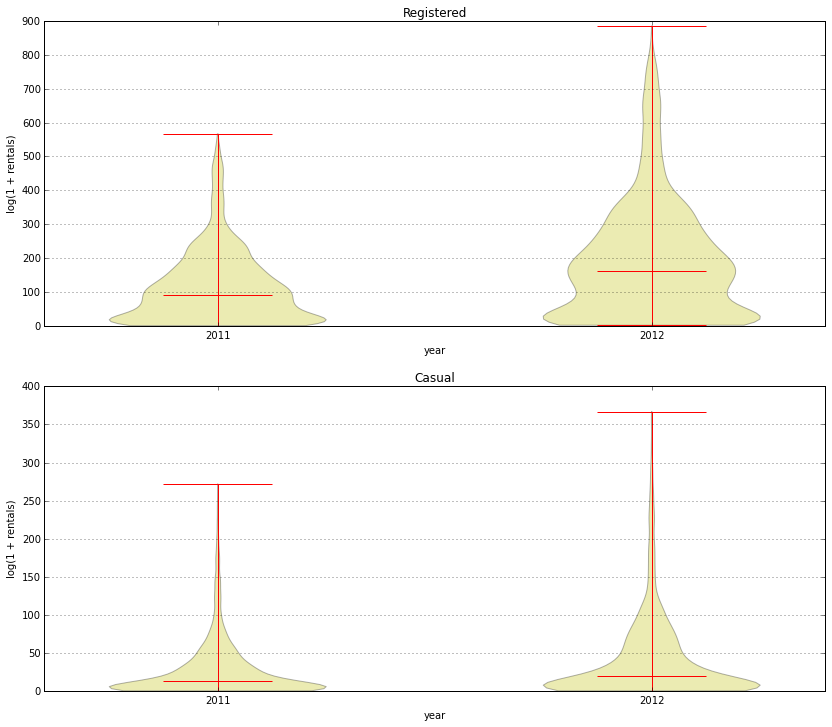

In [5]:
plot_by(train_registered_l1p, train_casual_l1p, train_year, 'year', 'log(1 + rentals)')

* There were more rentals in 2012 than 2011. It seems like the rentals are becoming more popular.

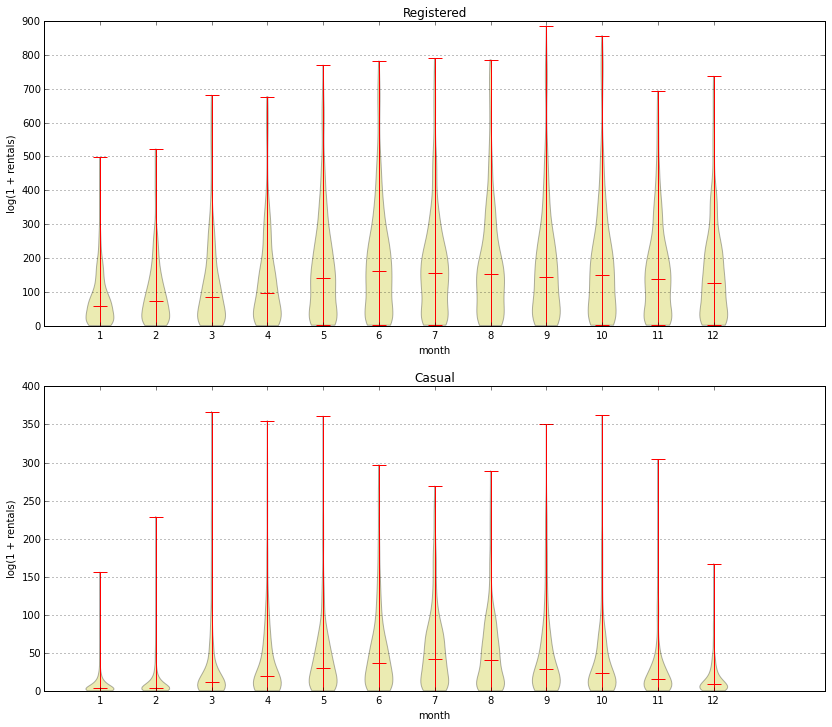

In [6]:
plot_by(train_registered_l1p, train_casual_l1p, train_month, 'month', 'log(1 + rentals)')

* The rentals seem to be more popular in the summer months. 
* There is an increasing trend throughout the year and a large drop from Dec to Jan for rentals by registered users. Why? This could be due to the popularity of the rentals growing steadily and the two Jan - Dec periods being added month-wise.

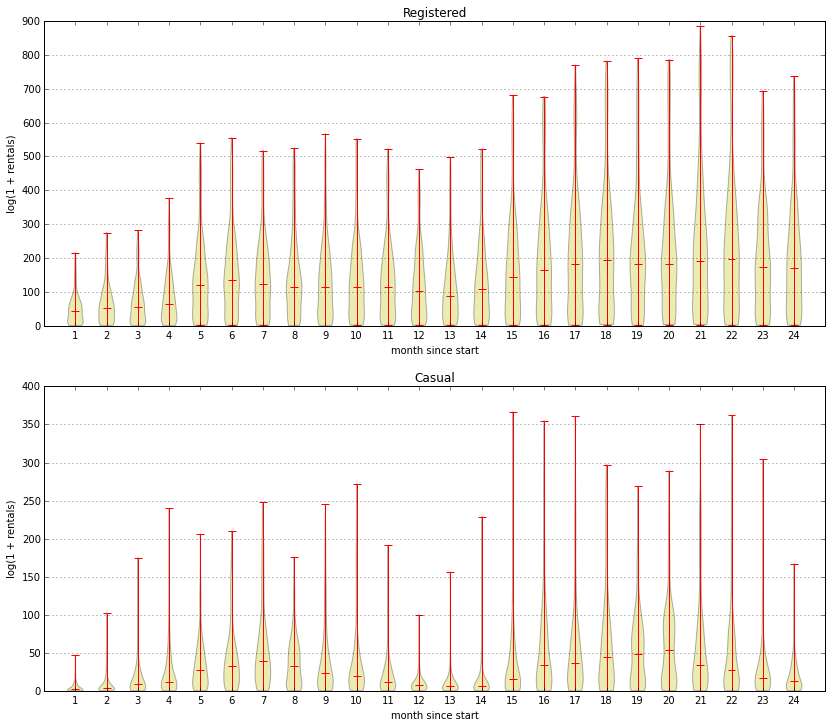

In [7]:
plot_by(train_registered_l1p, train_casual_l1p, train_month_since_start, 'month since start', 'log(1 + rentals)')

* This makes more sense: there is an overlap of a general trend and seasonality.
* Casual rentals seem to be quite popular in summer but not so much in winter.

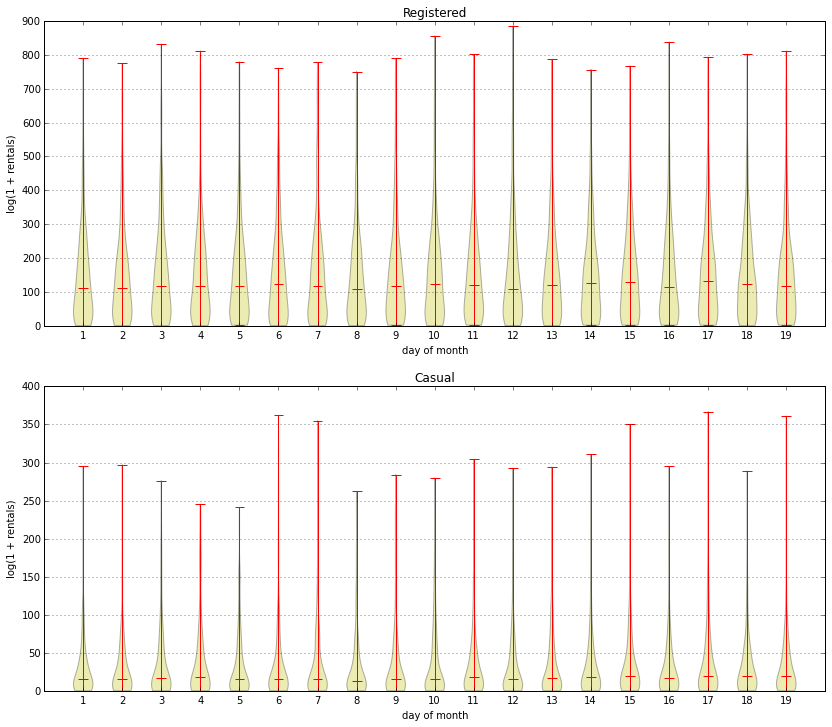

In [8]:
plot_by(train_registered_l1p, train_casual_l1p, train_day, 'day of month', 'log(1 + rentals)')

* So there is very little variation within the month (or at least within the 19 days in each month that are available for training). Makes sense.

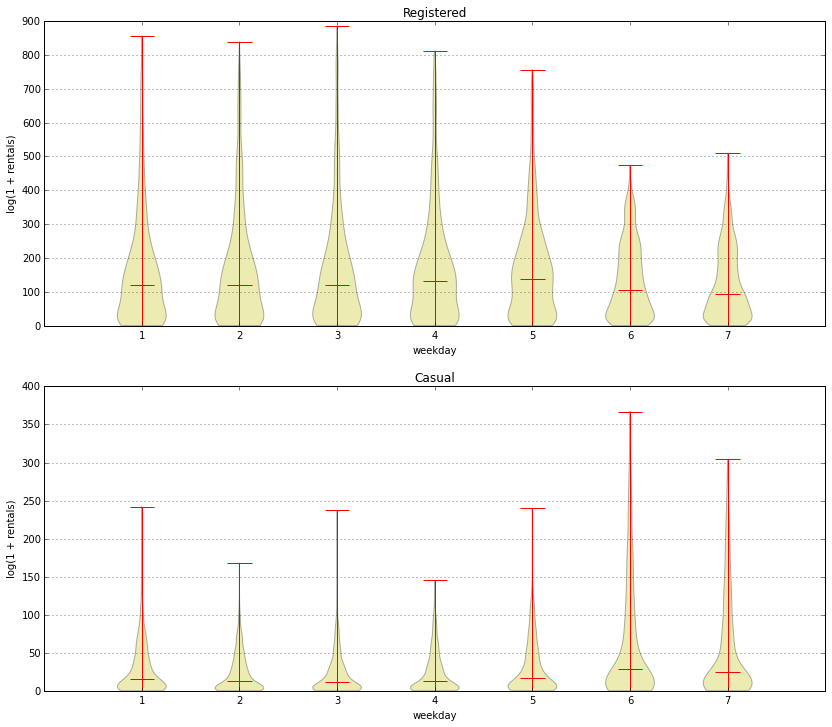

In [9]:
plot_by(train_registered_l1p, train_casual_l1p, train_wday, 'weekday', 'log(1 + rentals)')

* It seems a little surprising that there are less registered rentals at weekend when people have more free time.
* On the other hand, there are more casual rentals at weeekends.
* **Perhaps different models should be trained for weekdays and weekends?**

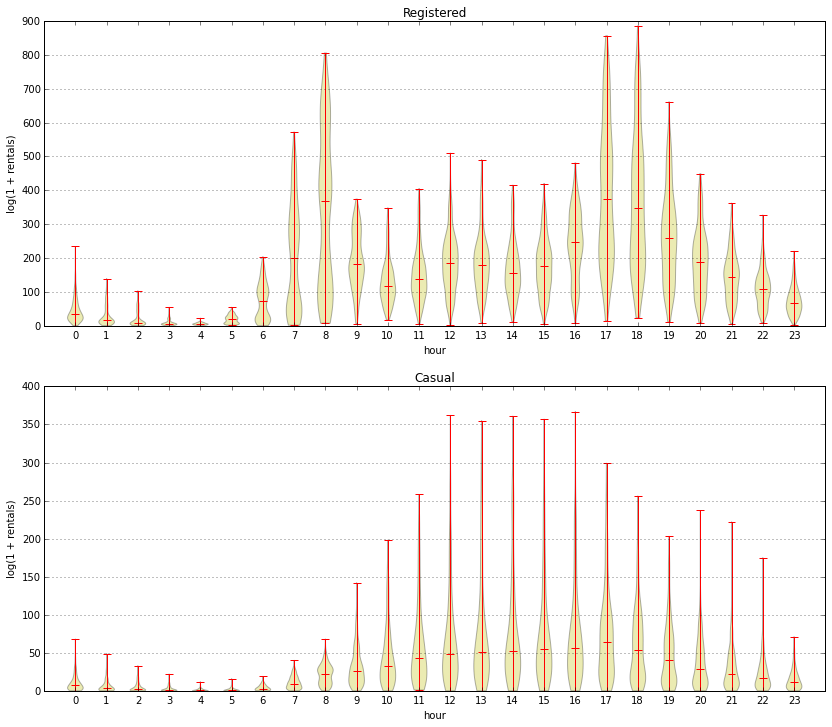

In [10]:
plot_by(train_registered_l1p, train_casual_l1p, train_hour, 'hour', 'log(1 + rentals)')

* Almost no rentals late at night (makes sense)
* There are peaks in registered rentals around morning and afternoon rush hours - no surprise, people are commuting to work
* There are more rentals in the afternoon than in the morning
* Casual rentals are most popular between late morning and early evening

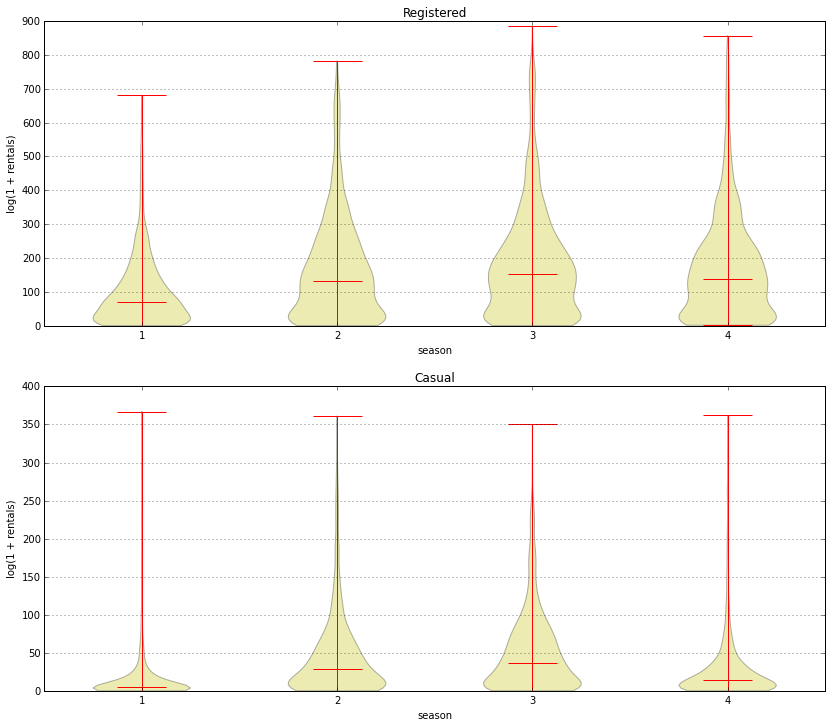

In [11]:
plot_by(train_registered_l1p, train_casual_l1p, train_season, 'season', 'log(1 + rentals)')

1 = spring, 2 = summer, 3 = fall, 4 = winter
* Summer and fall seem to be most popular seasons for bike rentals, but we must be careful about this because the rentals are growing steadily so there is an overlap of a trend and seasonality (like in the case of monthly data discussed before)

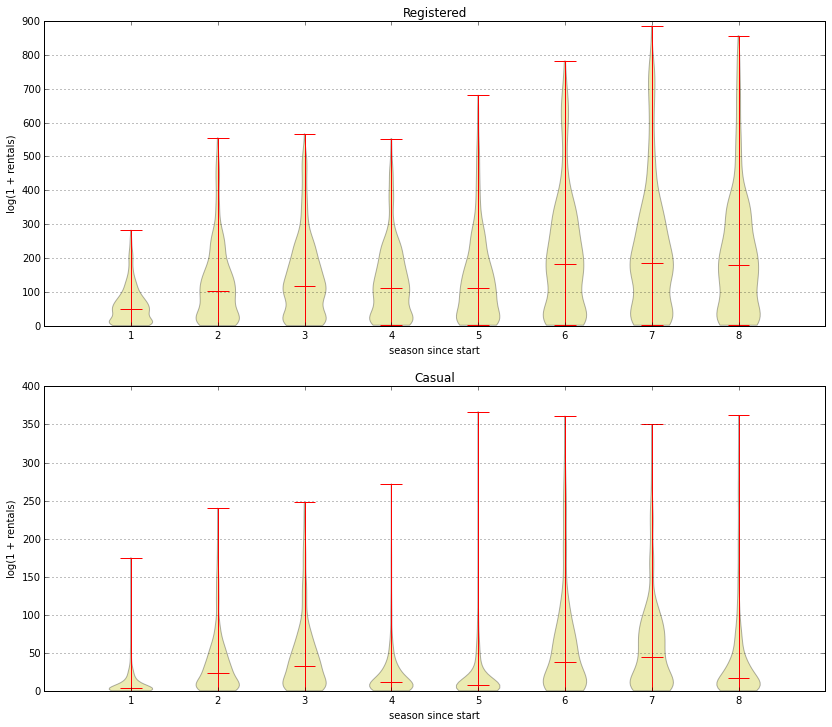

In [23]:
plot_by(train_registered_l1p, train_casual_l1p, train_season_since_start, 'season since start', 'log(1 + rentals)')

* Registered rentals rise quickly in the spring for both years. Maybe this is when people decide to start commuting by bike?
* Casual rentals are most popular in spring and summer but less so in autumn and winter
* A detailed look at the **training** data (in a text editor) shows that the seasons align nicely with months. This is important for the chart above because otherwise we could have a problem with combining data from year start and year end in one season, as early months and late Dec are all in winter (but they are different winters!). This is not the case with **test** data (seasons change in the later parts of Mar, Jun and Sep, and these parts are all in test data). 

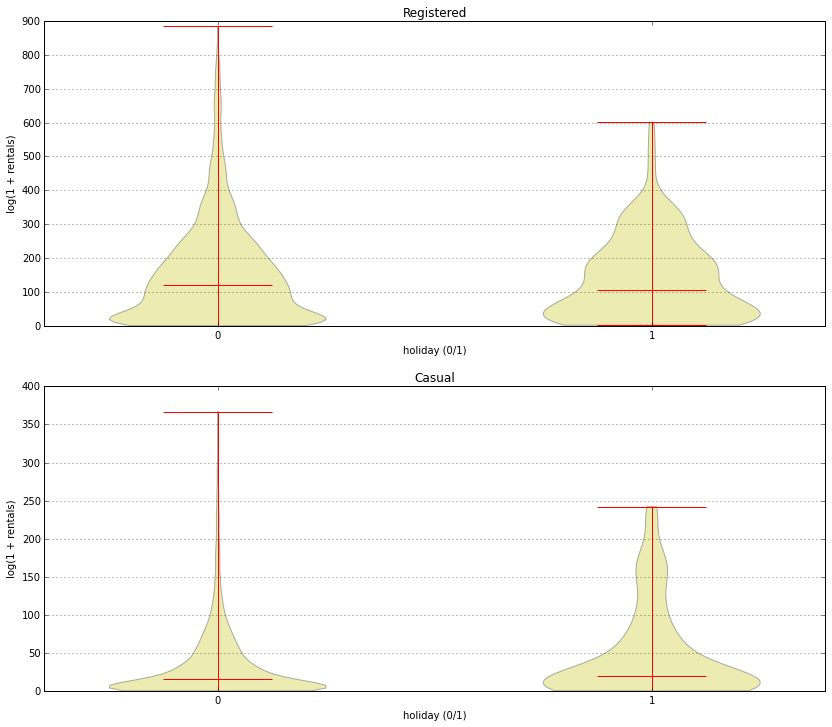

In [13]:
plot_by(train_registered_l1p, train_casual_l1p, train_holiday, 'holiday (0/1)', 'log(1 + rentals)')

* Registered rentals fall slightly on holidays (probably due to people not commuting to work)
* Casual rentals rise on holidays (probably people who don't normally use the service going out with friends who do, or tourists visiting the city deciding to move around on bikes)

In [28]:
print(np.sum(train_holiday))

311


* **There are only 311 recorded hours (about 13 days) of holiday rentals over 2 years. In addition, we can only use past data for prediction at any point, so holiday may be a confusing feature.**

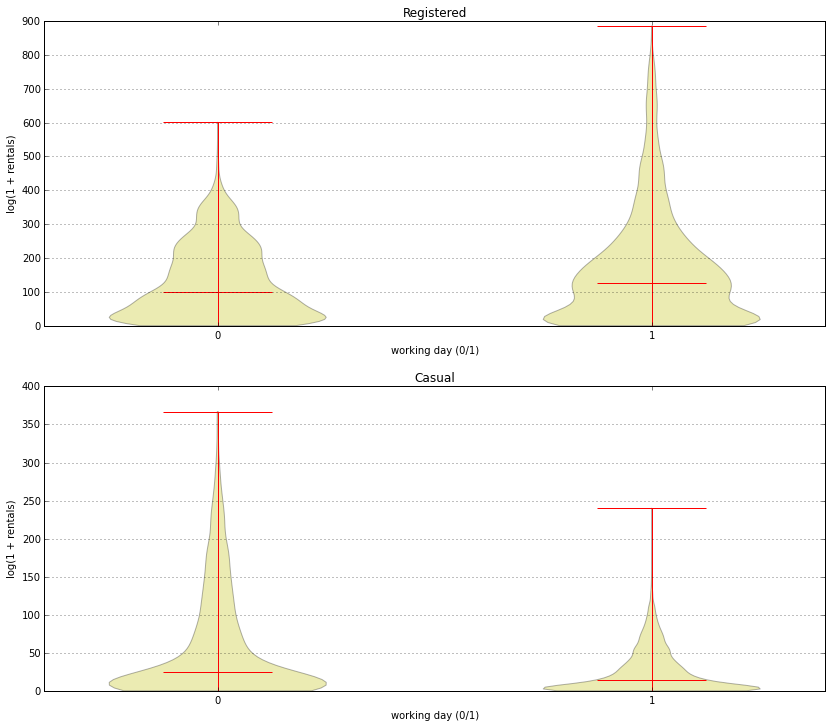

In [25]:
plot_by(train_registered_l1p, train_casual_l1p, train_workingday, 'working day (0/1)', 'log(1 + rentals)')

* There are more registered rentals and less casual rentals on working days. This is probably due to the same reasons as discussed for holidays above.

In [30]:
print(np.sum(train_workingday))
print(np.sum(np.logical_not(train_workingday)))

7412
3474


So we have a reasonable balance in this case.

In [16]:
for w in [1, 2, 3, 4]:
    print('Weather = ' + str(w) + ': ' + str(np.sum(train_weather == w)))

Weather = 1: 7192
Weather = 2: 2834
Weather = 3: 859
Weather = 4: 1


1: Clear, Few clouds, Partly cloudy, Partly cloudy

2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

* There is only 1 hour for Weather = 4, so we only produce violin plots for 1, 2 and 3.

In [31]:
train_weather_123 = train_weather[train_weather < 4]

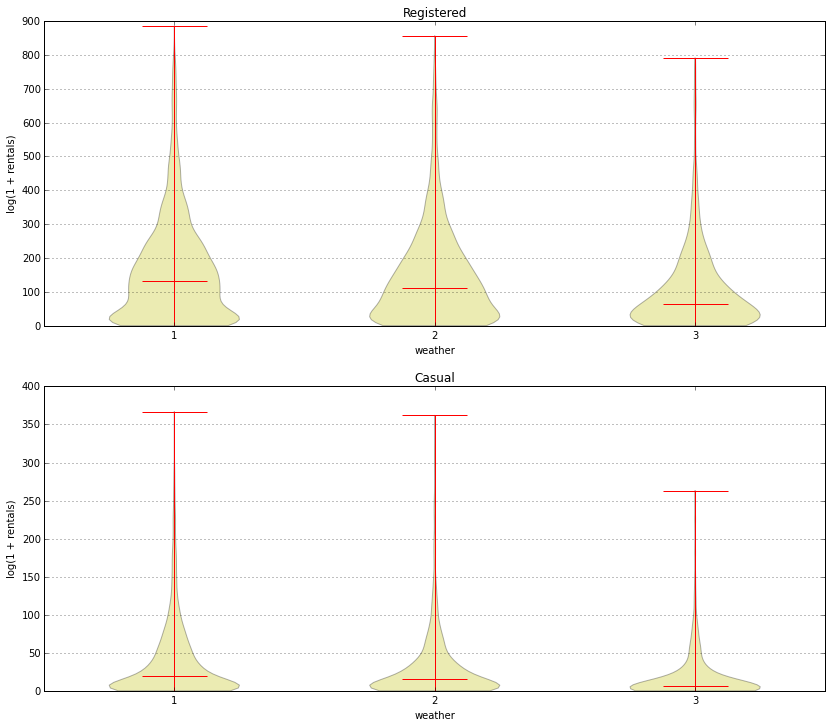

In [32]:
plot_by(train_registered_l1p, train_casual_l1p, train_weather_123, 'weather', 'log(1 + rentals)')

* People seem to be less likely to rent bikes as the weather gets worse - no surprise

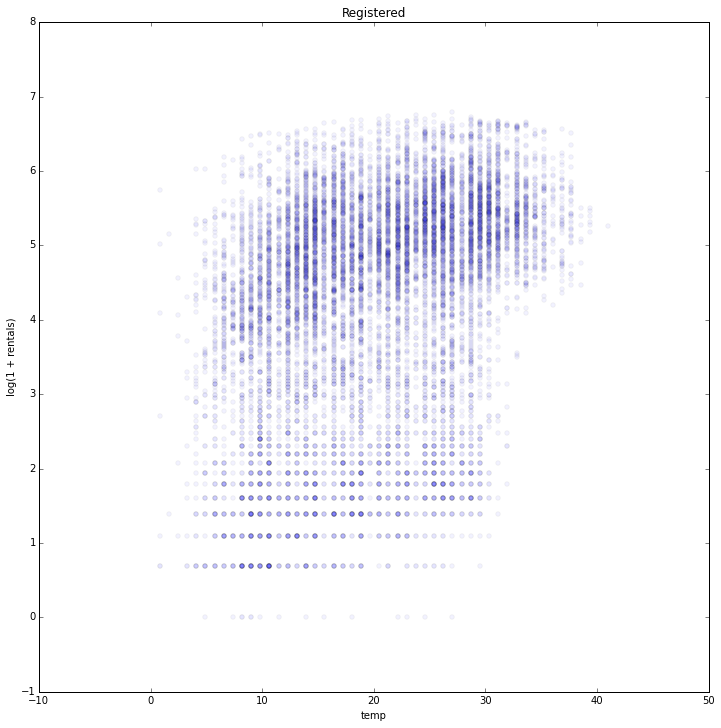

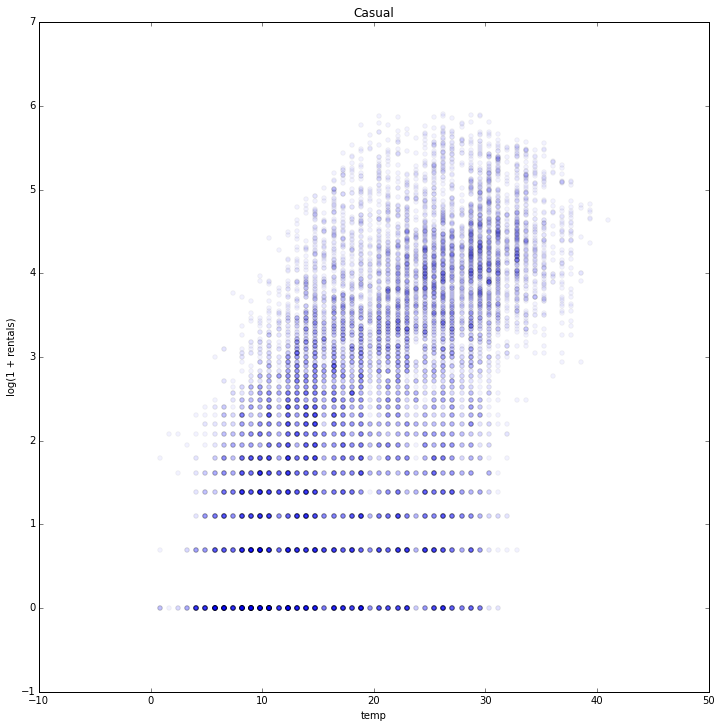

In [19]:
fig = plt.figure(figsize=(12, 12))
plt.scatter(train_temp, train_registered_l1p, c = 'b', s=20, marker='o', alpha=0.05)
plt.xlabel('temp')
plt.ylabel('log(1 + rentals)')
plt.title('Registered')

fig = plt.figure(figsize=(12, 12))
plt.scatter(train_temp, train_casual_l1p, c = 'b', s=20, marker='o', alpha=0.05)
plt.xlabel('temp')
plt.ylabel('log(1 + rentals)')
plt.title('Casual')

* There are more rentals as it gets warmer
* Casual rentals seem to be more sensitive to temperature

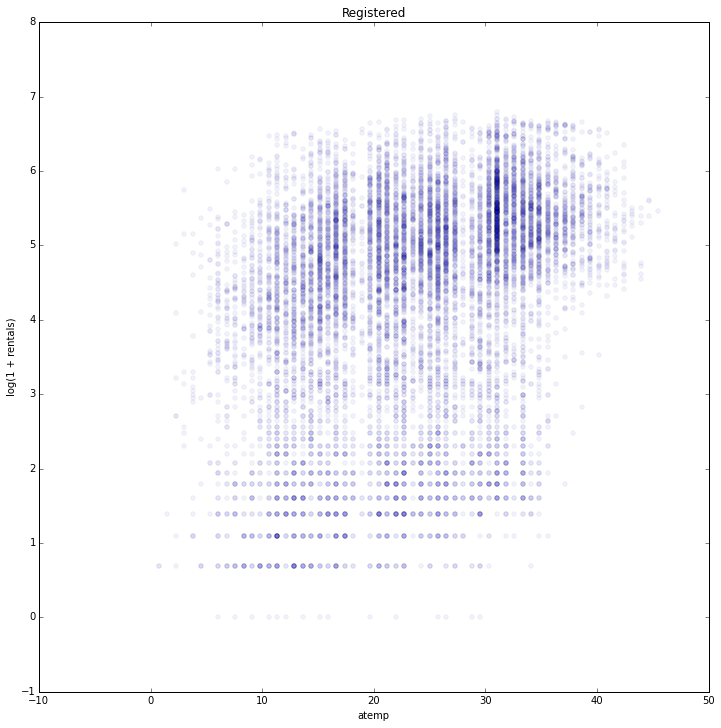

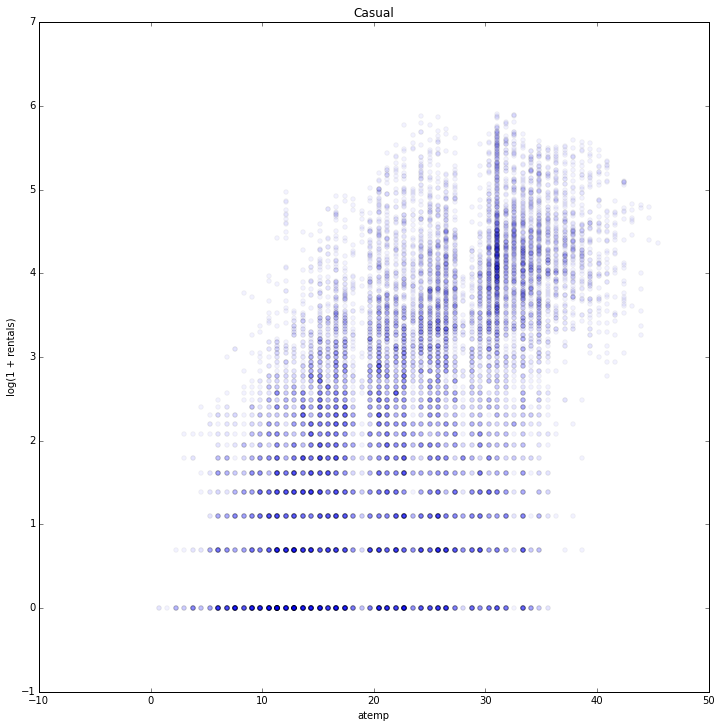

In [20]:
fig = plt.figure(figsize=(12, 12))
plt.scatter(train_atemp, train_registered_l1p, c = 'b', s=20, marker='o', alpha=0.05)
plt.xlabel('atemp')
plt.ylabel('log(1 + rentals)')
plt.title('Registered')

fig = plt.figure(figsize=(12, 12))
plt.scatter(train_atemp, train_casual_l1p, c = 'b', s=20, marker='o', alpha=0.05)
plt.xlabel('atemp')
plt.ylabel('log(1 + rentals)')
plt.title('Casual')

* The pattern for atemp ("feels like" temperature) is similar to the one for temp

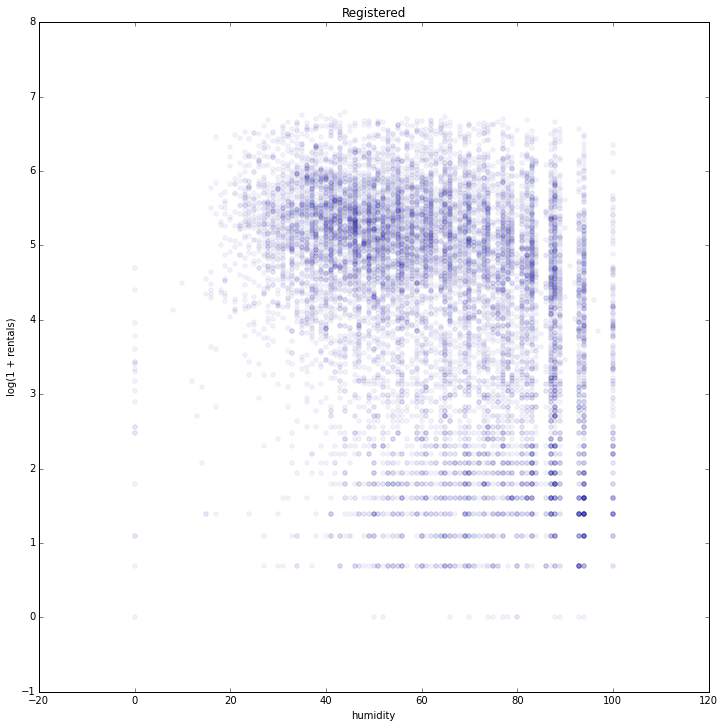

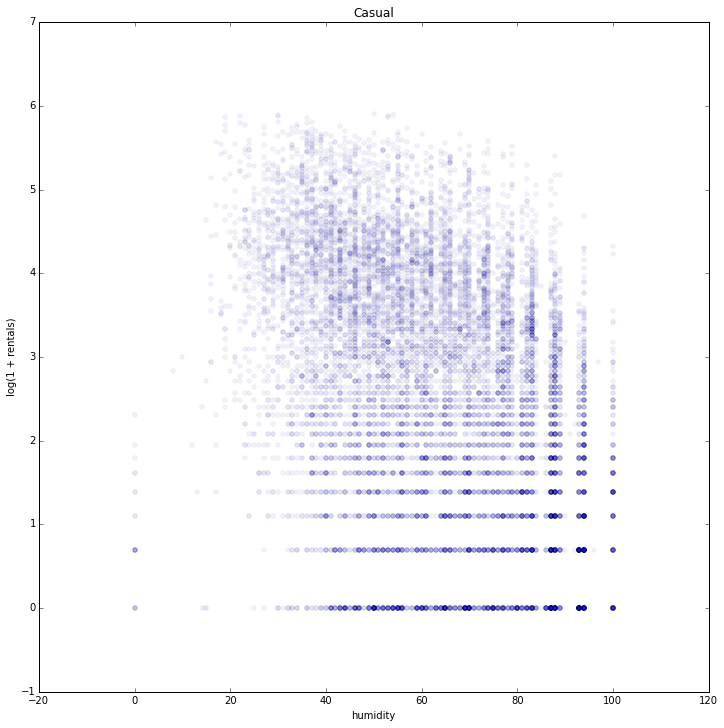

In [21]:
fig = plt.figure(figsize=(12, 12))
plt.scatter(train_humidity, train_registered_l1p, c = 'b', s=20, marker='o', alpha=0.05)
plt.xlabel('humidity')
plt.ylabel('log(1 + rentals)')
plt.title('Registered')

fig = plt.figure(figsize=(12, 12))
plt.scatter(train_humidity, train_casual_l1p, c = 'b', s=20, marker='o', alpha=0.05)
plt.xlabel('humidity')
plt.ylabel('log(1 + rentals)')
plt.title('Casual')

* High humidity seems to discourage people from renting bikes (humidity may be a proxy for rain). Casual rentals are particularly affected.

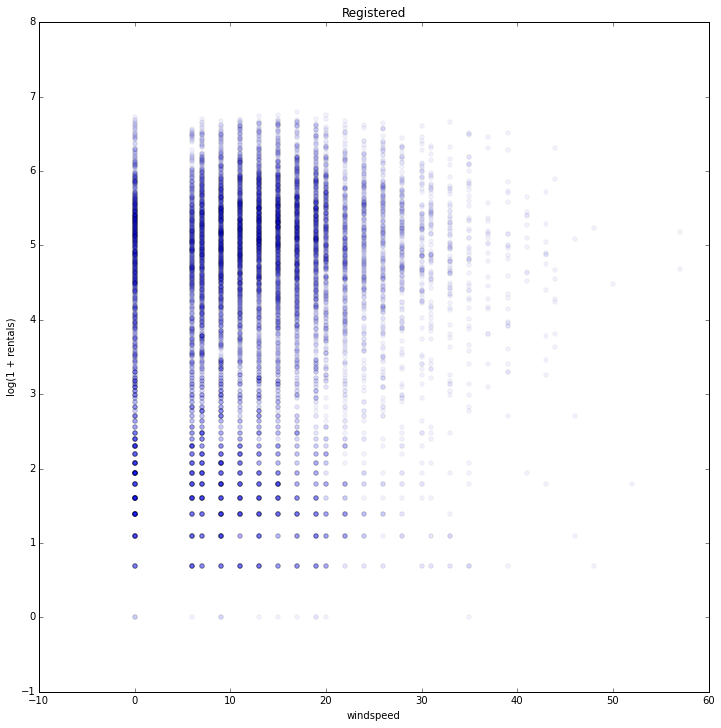

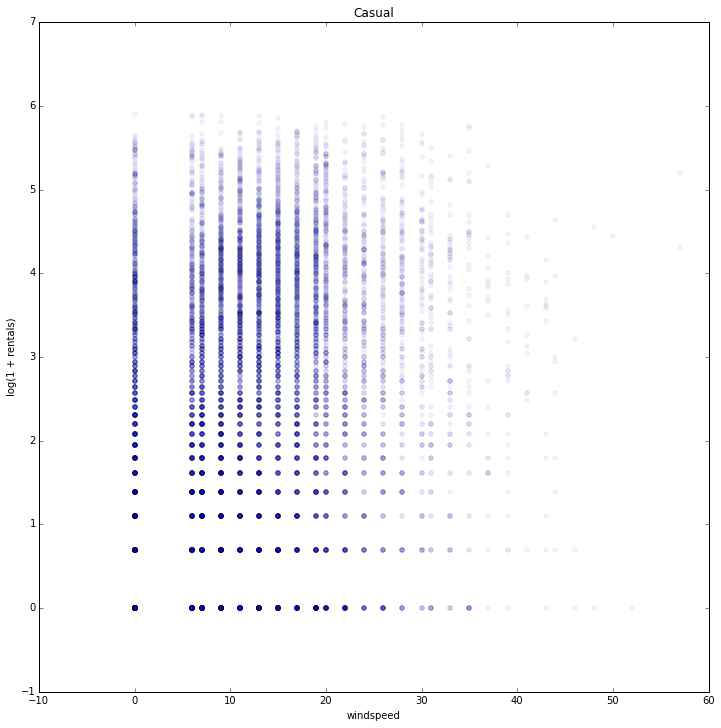

In [22]:
fig = plt.figure(figsize=(12, 12))
plt.scatter(train_windspeed, train_registered_l1p, c = 'b', s=20, marker='o', alpha=0.05)
plt.xlabel('windspeed')
plt.ylabel('log(1 + rentals)')
plt.title('Registered')

fig = plt.figure(figsize=(12, 12))
plt.scatter(train_windspeed, train_casual_l1p, c = 'b', s=20, marker='o', alpha=0.05)
plt.xlabel('windspeed')
plt.ylabel('log(1 + rentals)')
plt.title('Casual')

* Windspeed appears to be quantized (this may be a property of the method used to measure it)
* There seems to be no obvious effect of windspeed on rentals

## Conclusions

1. It seems to be a good idea to train separate models for registered and casual rentals, as they seem to respond differently to days off, weather etc.
1. There is only one (hour) record of weather = 4 (the most extreme), so this should be relabeled as 3 (effectively merging 3 and 4) or discarded to avoid problems
1. There are only 311 recorded hours (about 13 days) of holiday rentals over 2 years. In addition, we can only use past data for prediction at any point, so holiday may be a confusing feature.